In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
import statsmodels.api as sm
from scipy import stats
from scipy.stats import chi2_contingency
from statsmodels.formula.api import ols
from scipy.stats import ttest_ind
from scipy.stats import pearsonr

In [ ]:
demo = pd.read_sas('https://wwwn.cdc.gov/Nchs/Nhanes/2021-2022/DEMO_L.XPT', format='xport')
whd = pd.read_sas('https://wwwn.cdc.gov/Nchs/Nhanes/2021-2022/WHQ_L.XPT', format='xport')
dm = pd.read_sas('https://wwwn.cdc.gov/Nchs/Nhanes/2021-2022/DIQ_L.XPT', format='xport')
bp = pd.read_sas('https://wwwn.cdc.gov/Nchs/Nhanes/2021-2022/BPXO_L.XPT', format='xport')
glycohemo = pd.read_sas('https://wwwn.cdc.gov/Nchs/Nhanes/2021-2022/GHB_L.XPT', format='xport')
body = pd.read_sas('https://wwwn.cdc.gov/Nchs/Nhanes/2021-2022/BMX_L.XPT', format='xport')
chol_total = pd.read_sas('https://wwwn.cdc.gov/Nchs/Nhanes/2021-2022/TCHOL_L.XPT', format='xport')
phy = pd.read_sas('https://wwwn.cdc.gov/Nchs/Nhanes/2021-2022/PAQ_L.XPT', format='xport')
crp = pd.read_sas('https://wwwn.cdc.gov/Nchs/Nhanes/2021-2022/HSCRP_L.XPT', format='xport')


In [ ]:
nhanes_data = demo.merge(bp, on='SEQN', how='left') .merge(dm, on='SEQN', how='left') .merge(body, on='SEQN', how='left')\
                  .merge(glycohemo, on='SEQN', how='left') .merge(chol_total, on='SEQN', how='left') .merge(phy, on='SEQN', how='left')\
                  .merge(crp, on='SEQN', how='left') .merge(whd, on='SEQN', how='left')

In [ ]:
# Recoding Marital Status and Education Level columns
nhanes_data['DMDMARTZ'] = nhanes_data['DMDMARTZ'].apply(lambda x: 1 if x == 1 else 0)
nhanes_data['DMDEDUC2'] = nhanes_data['DMDEDUC2'].apply(lambda x: 1 if x in [4, 5] else 0)

# Replacing specific values in PAD680 and WHD020
nhanes_data['PAD680'] = nhanes_data['PAD680'].replace([7777, 9999], np.nan)
nhanes_data['WHD020'] = nhanes_data['WHD020'].replace([7777, 9999], np.nan)




Question 1: "Is there an association between marital status (married or not married) and education level (bachelor’s degree or higher vs. less than a bachelor’s degree)?"

Chi2 Statistic: 1677.006341355503, p-value: 0.0


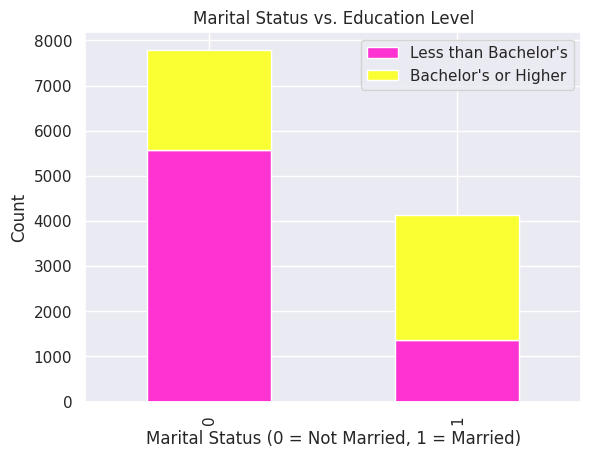

In [ ]:
# Calculating the contingency table and chi-square statistic
contingency_table = pd.crosstab(nhanes_data['DMDMARTZ'], nhanes_data['DMDEDUC2'])
chi2, p, dof, ex = chi2_contingency(contingency_table)

print(f"Chi2 Statistic: {chi2}, p-value: {p}")

# Plotting the contingency table with new colors
contingency_table.plot(kind="bar", stacked=True, color=["#FF33D1", "#F9FF33"])
plt.title("Marital Status vs. Education Level")
plt.xlabel("Marital Status (0 = Not Married, 1 = Married)")
plt.ylabel("Count")
plt.legend(["Less than Bachelor's", "Bachelor's or Higher"])
plt.show()

Question 2: "Is there a difference in the mean sedentary behavior time between those who are married and those who are not married?"

T-Statistic: -3.8740971309213887, p-value: 0.0001078679819334709


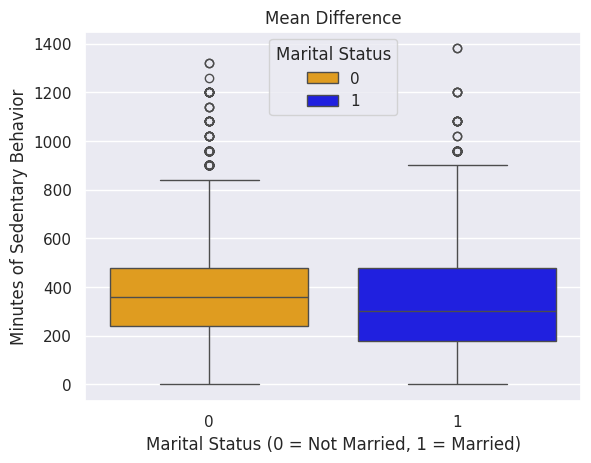

In [ ]:
# Filtering data for the t-test, separating married and not married groups based on 'DMDMARTZ' column
married = nhanes_data[nhanes_data['DMDMARTZ'] == 1]['PAD680'].dropna()
not_married = nhanes_data[nhanes_data['DMDMARTZ'] == 0]['PAD680'].dropna()

# Conducting an independent t-test to compare the mean sedentary behavior time between married and not married groups
t_stat, p_val = ttest_ind(married, not_married)

print(f"T-Statistic: {t_stat}, p-value: {p_val}")

sns.boxplot(x='DMDMARTZ', y='PAD680', data=nhanes_data,hue='DMDMARTZ', palette=['orange', 'blue'])
plt.xlabel('Marital Status (0 = Not Married, 1 = Married)')
plt.ylabel('Minutes of Sedentary Behavior')
plt.legend(title="Marital Status")
plt.title('Mean Difference')
plt.show()



Question 3: "How do age and marital status affect systolic blood pressure?"

                   sum_sq      df            F    PR(>F)
C(DMDMARTZ)  1.737748e+03     1.0     6.860916  0.008828
RIDAGEYR     5.889160e+05     1.0  2325.138035  0.000000
Residual     1.893791e+06  7477.0          NaN       NaN


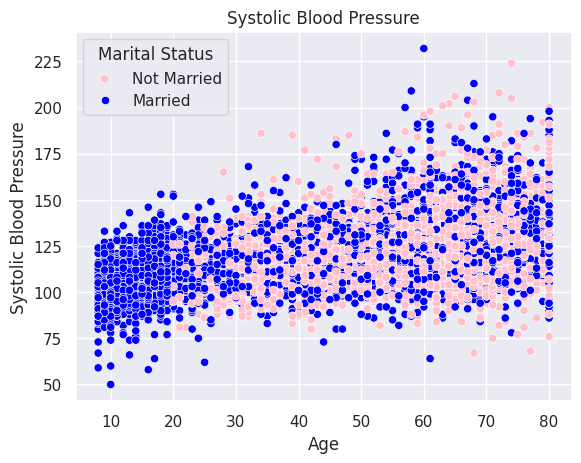

In [ ]:
 #Defining the OLS model with the correct 'data' argument
model = ols('BPXOSY3 ~ RIDAGEYR + C(DMDMARTZ)', data=nhanes_data).fit()

# Generating the ANOVA table
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

sns.scatterplot(x='RIDAGEYR', y='BPXOSY3', hue='DMDMARTZ', data=nhanes_data, palette=['blue', 'pink'])
plt.title("Systolic Blood Pressure")
plt.xlabel("Age")
plt.ylabel("Systolic Blood Pressure")
plt.legend(title="Marital Status", labels=["Not Married", "Married"])
plt.show()


Question 4: "Is there a correlation between self-reported weight and minutes of sedentary behavior?"



Correlation: 0.1559714584645021, p-value: 1.6988498386828133e-44


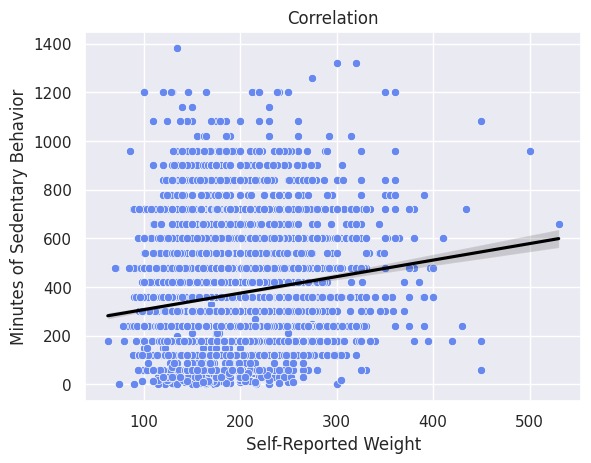

In [ ]:
subset_nhanes_data = nhanes_data[['WHD020', 'PAD680']].dropna()

# Performing Pearson correlation
correlation, p_value = pearsonr(subset_nhanes_data['WHD020'], subset_nhanes_data['PAD680'])
print(f"Correlation: {correlation}, p-value: {p_value}")

sns.scatterplot(x='WHD020', y='PAD680', data=nhanes_data)
sns.regplot(x='WHD020', y='PAD680', data=nhanes_data, scatter=False, color='black')
plt.xlabel("Self-Reported Weight")
plt.ylabel("Minutes of Sedentary Behavior")
plt.title("Correlation")
plt.show()

Question 5 (Creative Analysis): "Is there a difference in the mean sedentary behavior time between education status?"

T-Statistic: -12.654138875237726, p-value: 2.3489432174688958e-36


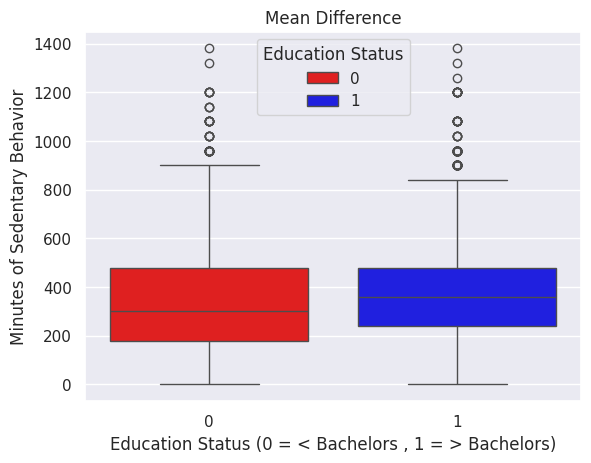

In [ ]:
# Filtering data for the t-test, separating education status based on 'DMDEDUC2' column
More_than_Bachelors = nhanes_data[nhanes_data['DMDEDUC2'] == 1]['PAD680'].dropna()
Less_than_Bachelors = nhanes_data[nhanes_data['DMDEDUC2'] == 0]['PAD680'].dropna()

# Conducting an independent t-test to compare the mean sedentary behavior time between education status
t_stat, p_val = ttest_ind(Less_than_Bachelors, More_than_Bachelors)

print(f"T-Statistic: {t_stat}, p-value: {p_val}")

sns.boxplot(x='DMDEDUC2', y='PAD680', data=nhanes_data,hue='DMDEDUC2', palette=['red', 'blue'])
plt.xlabel('Education Status (0 = < Bachelors , 1 = > Bachelors)')
plt.ylabel('Minutes of Sedentary Behavior')
plt.legend(title="Education Status")
plt.title('Mean Difference')
plt.show()